In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from numpy import pi as npi
from scipy.stats import multivariate_normal
from dynesty import NestedSampler
from dynesty.utils import resample_equal
import corner
from scipy.stats import norm

## Let us make some simulated data that we can then used to fit an autoregressive process. This looks like decays like a powerlaw with some strucure -- perhaps a transient light curve?

Text(0, 0.5, '$\\mathcal{L}$')

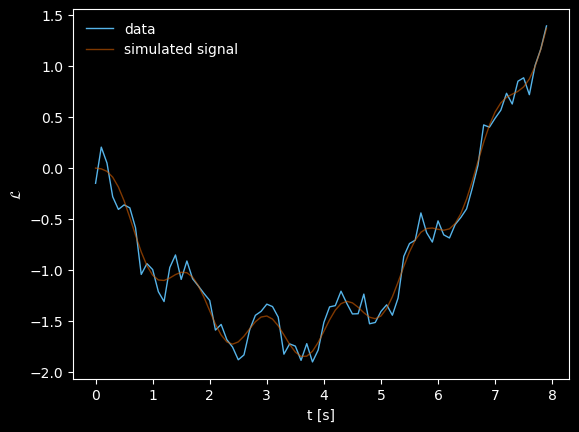

In [14]:
A0_inj, f0_inj = 0.2, 0.75
noise_sigma = 1.0
times = np.arange(0, 8, 0.1)
noise_sigma = 0.1


injection = A0_inj * np.sin(2*npi*f0_inj*times) - times + 0.15*times**2
data = injection + noise_sigma*np.random.normal(size=times.size)

## Lets make some plots of out data to check that it looks ok
ax = plt.gca()

# time domain plot
ax.plot(times, data, label='data', color='#56B4E9', lw=1.0)
ax.plot(times, injection, label='simulated signal', color='#D55E00', lw=1.0, alpha=0.6)
ax.legend(frameon=False)
ax.set_xlabel('t [s]')
ax.set_ylabel('$\mathcal{L}$')

In [15]:
## We want to fit a CAR(1) process to this. How many independent parameters do we have? 

print('we have ' + str(times.size + 3) + ' parameters!')

we have 83 parameters!


### Unmdoeled fitting. 

We will use a nested sampler called dynesty to sample this high dimensional space. Nested samplers usually produce random samples from a uniform N-dimensional unit hypercube, where N is the number of independent parameters. 

$$\theta_i \sim U[0, 1) \qquad i \in [1, N]$$

We need to provide a nested sampler two functions to work. 

1. A prior transformation function to transform the unit hypercube draws into draws from out actual prior. 

In the example below the function function `AR1` serves as the prior transformation function. It provides a uniform prior for $b, \tau and \sigma$. It also provides a uniform prior for each $\psi_i \sim U[-6, 6]$

2. A likelihood function to calculate $p(d | \theta)$ for our draws. 


Remember that for a $CAR(1)$ process

$$p\left (\psi(t) | \psi(t'), \tau, \sigma, b \right) = \frac{1}{\sqrt{2 \pi \Omega(t)}} \exp \left [ - \frac{\left( \psi^*(t) - \hat{\psi} (t) \right)^2}{2 \Omega^2(t)}\right]$$


where $$\hat{\psi}(t) \equiv E \left (\psi(t) | \psi (t') \right) - b \tau  = e^{-\Delta t / \tau} \left (\psi(t') - b \tau \right )$$


and $$\Omega(t) = \frac{\tau \sigma^2}{2} \left(1 - e^{-2 \Delta t / \tau} \right)$$


$$p\left ( \psi(t_1), \psi(t_2), ..., \psi(t_n)  |\tau, \sigma, b \right) = \prod_i^n \frac{1}{\sqrt{2 \pi \Omega(t)}} \exp \left [ - \frac{\left( \psi^*(t_i) - \hat{\psi} (t_i) \right)^2}{2 \Omega^2(t_i)}\right]$$

Finally we still need the data likelihood, since this is a noisy process

$$p(d |\psi(t_1), \psi(t_2), ..., \psi(t_n)) = \prod_i^n \frac{1}{\sqrt{2 \pi \sigma_n}} \exp \left [ - \frac{\left( \psi(t_i) - d_i \right)^2}{2 \sigma_n^2}\right] $$


The full likelihood is the product of these two things. 

In [16]:
class nested_sample_autoreg():

    def __init__(self, data, times, noise_sigma):
        self.data = data
        self.times = times
        self.delt = times[1] - times[0]
        self.noise_sigma = noise_sigma
        self.npar = self.times.size + 3

    def AR1(self, theta):

        '''
        prior function
        -------------
        
        samples from a 
        
        
        
        '''
        
        min_vals = np.array([-6, 0.001, 0.01])
        max_vals = np.array([6, 15, 10])
        
        theta[0:3] = (max_vals - min_vals) * theta[0:3] + min_vals

        theta[3:] = -6 + theta[3:]*12 # psi_i between [-6, 6]
    
        return theta
    

    def loglike(self, theta,):

        b, tau, sigma = theta[0], theta[1], theta[2]
        
        ## these are the values at the nodes
        psi_i = theta[3:]

        
        ## the mean-subtracted values i.e. psi*
        psi_star = psi_i - b*tau
        
        
        ## initializing an array of autoregressive predictions
        psi_hat = np.zeros(psi_i.size)
        
    
        # the first element we leave zero
        psi_hat[1:] = np.exp(-self.delt / tau) * (psi_star[0:-1]) 
        
        var = 0.5*tau*sigma**2 * (1 - np.exp(-2*self.delt / tau))
        
        # probability for the CAR(1) model. 
        log_prob = - 0.5 * (psi_star - psi_hat)**2 / var  - 0.5 * np.log(2 * np.pi * var)
        
        # log-likelihood for the data
        loglike = -0.5 * (self.data - psi_i)**2 / self.noise_sigma**2

        
        ## its generally better to work with log probabilities when you have 
        ## to take products over many terms to avoid overflow errors
    
        return loglike.sum() + log_prob.sum()



## Ok, now lets run the nested sampler

In [17]:
ar_obj = nested_sample_autoreg(data, times, noise_sigma)

engine = NestedSampler(ar_obj.loglike, 
                       ar_obj.AR1, ar_obj.npar,
                       bound='multi', nlive=250)
engine.run_nested(dlogz=0.1,print_progress=True )

70815it [15:23, 76.64it/s, +250 | bound: 3266 | nc: 1 | ncall: 31641650 | eff(%):  0.225 | loglstar:   -inf < 22.857 <    inf | logz: -257.579 +/-  1.027 | dlogz:  0.000 >  0.100] 


## we can plot the distribution of the global parameters

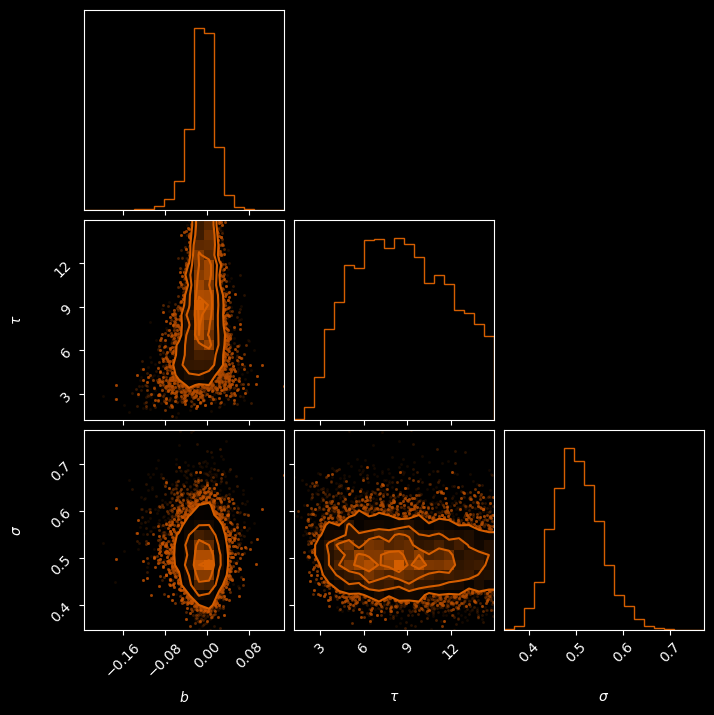

In [18]:
res = engine.results
weights = np.exp(res['logwt'] - res['logz'][-1])
weights[-1] = 1 - np.sum(weights[0:-1])

post_samples = resample_equal(res.samples, weights)
fig = corner.corner(
    post_samples[:, 0:3], 
    labels=['$b$', '$\\tau$', '$\\sigma$'], color='#D55E00')

### Now lets compare the fit against the simulated signal (i.e. without noise)

Text(0, 0.5, '$h(t)$')

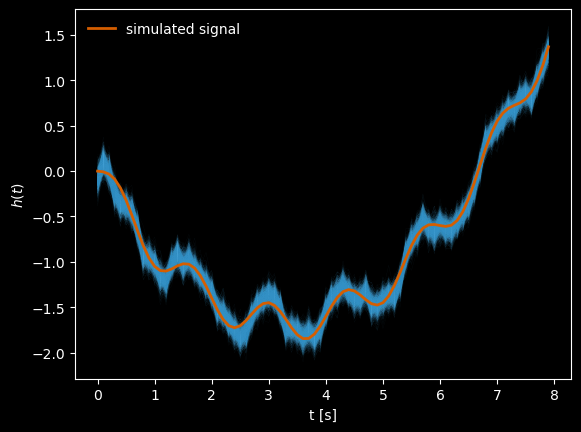

In [19]:
fis = post_samples[:, 3:]

ax = plt.gca()


for ii in range(2000):
    ax.plot(times, fis[ii, :], alpha=0.1, color='#56B4E9', lw=0.15)

ax.plot(times, injection, label='simulated signal', color='#D55E00', lw=2.0)
ax.legend(frameon=False)
ax.set_xlabel('t [s]')
ax.set_ylabel('$h(t)$')